In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim, utils

In [47]:
# Creating data frames for both csv files
genotypes_df = pd.read_csv(
    'data/genotypes.csv'
)
phenotypes_df = pd.read_csv(
    'data/phenotype_df.csv',
    usecols=[4]
)

In [48]:
# Excluding 'sample_id'
genotypes_vals = genotypes_df.iloc[:, 1:].values    

# Assuming equal weights
weights = np.ones(genotypes_df.shape[1]-1)

# Dot product for weighted sum
gene_burdens = np.dot(genotypes_vals, weights).reshape(-1, 1)

In [49]:
# Shuffling the matrices values for uniform random sampling
g = gene_burdens
p = phenotypes_df.values

# Shuffling indices along columns
indices = np.arange(len(g))
np.random.shuffle(indices)

# Reordering with new indices
g = g[indices]
p = p[indices]

# Calculatign the index required for the split
split_index = int(0.8 * len(g))

g_tr = g[:split_index]  
g_te = g[split_index:]

p_tr = p[:split_index]
p_te = p[split_index:]

print(g_tr.shape)
print(g_te.shape)

(1600, 1)
(400, 1)


In [50]:
def linear_regression(X, y, alpha):

    X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
    _, n_features = X.shape

    # L2 regularization
    
    I = np.eye(n_features) # Creating an identity matrix of size n_features to allow for matrix addition
    theta = np.linalg.solve(X.T @ X + alpha * I , X.T @ y)

    yhat = X @ theta

    train_error = np.mean((yhat - y) ** 2)

    print("Training error:" , train_error)

    plt.plot(X[:, 1], y, "bo", X[:, 1], yhat, "r")

    return theta, yhat

Training error: 0.9864161781030752


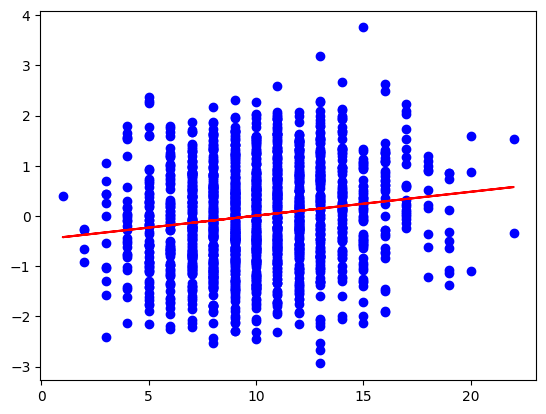

In [51]:
theta, yhat_train = linear_regression(g_tr, p_tr, 0.1)

Testing error: 0.964263934041548


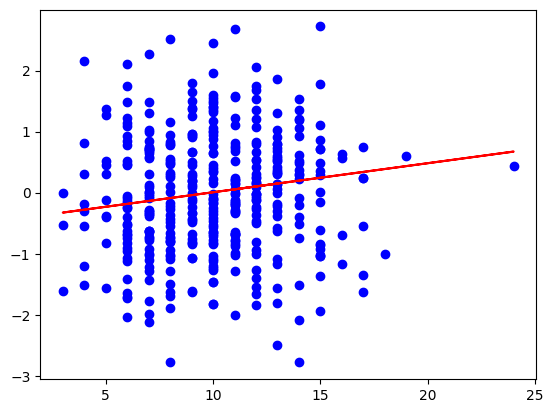

In [52]:
X_te = g_te

X_te = np.concatenate([np.ones((X_te.shape[0], 1)), X_te], axis=1)

yhat_test = X_te @ theta

test_error = np.mean((yhat_test - p_te) ** 2)

print("Testing error:", test_error)

plt.plot(X_te[:, 1], p_te, "bo", X_te[:, 1], yhat_test, "r")

In [127]:
train_g_tensor = torch.from_numpy(g_tr)
train_p_tensor = torch.from_numpy(p_tr)

train_dataset = utils.data.TensorDataset(
    train_g_tensor,
    train_p_tensor
)

test_g_tensor = torch.from_numpy(g_te)
test_p_tensor = torch.from_numpy(p_te)

test_dataset = utils.data.TensorDataset(
    test_g_tensor,
    test_p_tensor
)

train_dataloader = utils.data.DataLoader(
    train_dataset,
    batch_size=40,
    shuffle=True
)

test_dataloader = utils.data.DataLoader(
    test_dataset,
    batch_size=40,
    shuffle=False
)

In [128]:
class MyNN(nn.Module):
  def __init__(self, ni, nh, no):
    super().__init__()
    self.layer1 = nn.Linear(ni,nh)
    
    self.layer2 = nn.Linear(nh, nh)

    self.layer3 = nn.Linear(nh, no)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    
    x = self.layer2(x)
    x = self.relu(x)

    x = self.layer3(x)
    return x

In [129]:
def train(dataloader, n_epoch, net, opt, device):
  ls = []
  loss_function = nn.MSELoss()  # MSE loss for linear regression
  
  for i in range(n_epoch):
    total_loss = 0
    for batch in dataloader:
      X, y = batch[0].to(device).float(), batch[1].to(device).float()
      yhat = net(X)
      loss = loss_function(yhat, y)
      opt.zero_grad()
      loss.backward()
      opt.step()

      total_loss += loss.item()
      
    ls.append(total_loss/len(dataloader))

  plt.plot(ls)
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

  return ls[len(ls)-1]

In [130]:
device = torch.device("cuda:0")
net = MyNN(1, 20, 1).to(device)
opt = optim.SGD(net.parameters(), lr = 2e-3 , momentum = 0)

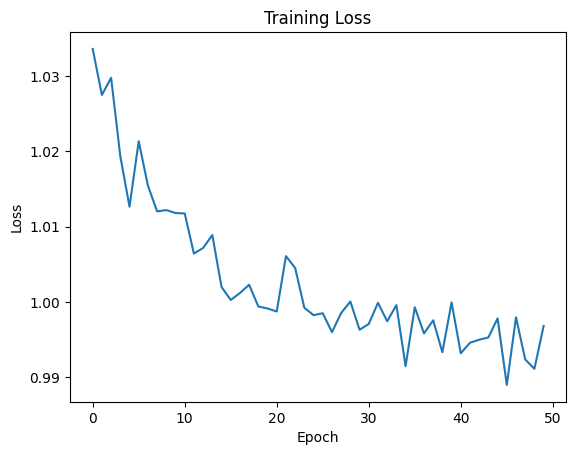

In [131]:
train_loss = train(train_dataloader, 50, net, opt, device)

In [141]:
print("Final train loss: ", train_loss)

Final train loss:  0.9967873752117157


In [142]:
def test(dataloader, net):
  net.eval()
  loss_function = nn.MSELoss()  # MSE loss for linear regression
  with torch.no_grad():
    total_loss = 0
    for batch in dataloader:
      X, y = batch[0].to(device).float(), batch[1].to(device).float()
      yhat = net(X)
      loss = loss_function(yhat, y)
      total_loss += loss.item()

    return total_loss/len(dataloader)

In [143]:
test_loss = test(test_dataloader, net)
print("Test loss: ", test_loss)

Test loss:  0.9578571379184723


Because the gene burden accounts for only a small fraction of the total variability in LDL levels, we can see that there is little to no improvement between using a simple linear model and a fully connected neural network.